In [5697]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.stattools import adfuller, kpss
import pandas as pd
from sklearn import linear_model
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from scipy import stats


%matplotlib inline
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

plt.rcParams["figure.figsize"] = (12, 4)

In [5698]:
inputdata1 = "../output_qt/combined_qt_data/"
outputdata1 = "../output_qt/regressiondata_qt/"

In [5699]:
def get_data():
    get_data = pd.read_csv(inputdata1 + "a0_combinedQuarterly_extended_ARIMA.csv", index_col=0)
    first_date = get_data.index[0]

    get_data.index = pd.date_range(first_date, get_data.index[-1], freq='QS').date
    return get_data

df = get_data()

In [5700]:
from sklearn.preprocessing import StandardScaler
import random

# subset of the data
df1 = df[[
        # 'gdp_total',
        # 'imports_goods_services',
        # 'household_cons',
        # 'gov_consumption', 
        # 'investments', 
        # 'gpd_invest_business_households',
        # 'gov_invest', 
        # 'change_supply', 
        # 'exports_goods_services',
        'gdp_total_deseasonalized', 
        'imports_goods_services_deseasonalized',
        'household_cons_deseasonalized', 
        'gov_consumption_deseasonalized',
        'investments_deseasonalized',
        'gpd_invest_business_households_deseasonalized',
        'gov_invest_deseasonalized', 
        'change_supply_deseasonalized',
        'exports_goods_services_deseasonalized',
        'BeloningSeizoengecorrigeerd_2', 
        'Loonkosten_7',
        'BeloningVanWerknemers_8', 
        'Germany_GDP',
        'France_GDP', 
        'Italy_GDP', 
        'Spain_GDP', 
        'Belgium_GDP' 
        ]]

In [5701]:

#############################
# change name if seasonally adjusted for code consistency
#############################
if(any([col for col in df1.columns if 'gdp_total_deseasonalized' in col])):
    df1.insert(0, 'gdp_total', df1.pop('gdp_total_deseasonalized'))

### Add 'sure' data and random data

In [5702]:

# create a sure-fire predictor
df1['gdp_total_dirty_0'] = [random.random() * 20000 for _ in range(0, len(df1))] + df1['gdp_total']
df1['gdp_total_dirty_1'] = [random.random() * 20000 for _ in range(0, len(df1))] + df1['gdp_total']

# randos
df1['random_0'] = [random.random() for _ in range(0, len(df1))] 
df1['random_1'] = [random.random() for _ in range(0, len(df1))] 

print(df1.shape)

(119, 21)


### Log and scale data

In [5703]:
# scale data to make comparable

def log_data(data,seasonal_only = True):


    if seasonal_only:
        df2 = np.log(data.loc[:, ~data.columns.isin(['change_supply_deseasonalized'])])
        df2['change_supply_deseasonalized']= data['change_supply_deseasonalized']
        data = df2.copy()

    else:
        df2 = np.log(data.loc[:, ~data.columns.isin(['change_supply', 'change_supply_deseasonalized'])])
        df2['change_supply']= data['change_supply']
        df2['change_supply_deseasonalized']= data['change_supply_deseasonalized']
        data = df2.copy()

    return data

df1 = log_data(df1, seasonal_only=True)

(119, 21)


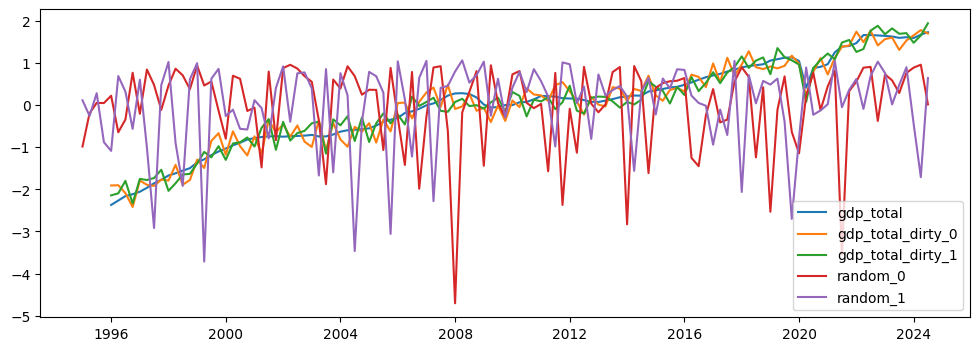

In [5704]:
scaler = StandardScaler()
df1_scaled = scaler.fit_transform(df1)

scaled_features_df = pd.DataFrame(df1_scaled, index=df1.index, columns=df1.columns)
scaled_features_df[['gdp_total','gdp_total_dirty_0','gdp_total_dirty_1', 'random_0', 'random_1']].plot()
scaled_features_df.head()

print(scaled_features_df.shape)

In [5705]:
#############################
# Dataframe of column names for storing tests
#############################

STORE_FOR_TESTS = pd.DataFrame(columns=scaled_features_df.columns).T

STORE_FOR_TESTS['Qt_Seasonality'] = np.nan
STORE_FOR_TESTS['Semi_Seasonality'] = np.nan
STORE_FOR_TESTS['Level_Stationary'] = np.nan
STORE_FOR_TESTS['Difference_Stationary'] = np.nan
STORE_FOR_TESTS['Difference_Data'] = 'False'

In [5706]:
def seasonality_test(data):
    kw_test1 = data.iloc[0:100,:]
    kw_test1['Qts'] = [1,2,3,4] * int(len(kw_test1)/4)
    kw_test1['Semi'] = [1,2] * int(len(kw_test1)/2)
    kw_test1.dropna(inplace=True)
    
    return kw_test1

kw1 = seasonality_test(scaled_features_df)

### Deseasonalize if needed (Kruskal-Wallis test)

(119, 21)


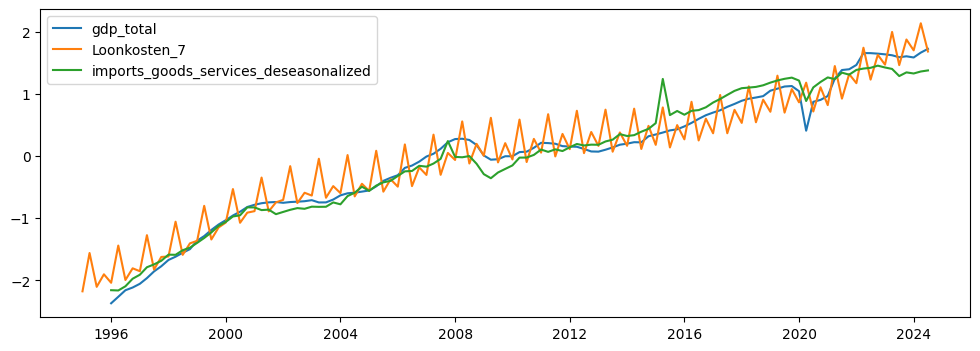

In [5707]:
scaled_features_df[['gdp_total', 'Loonkosten_7', 'imports_goods_services_deseasonalized']].plot()

print(df1.shape)

In [5708]:
def Kruskal_Wallis_Qt(data, STORE_FOR_TESTS): # Quarterly seasonality
    
    for col in data.columns:
        # no need to test these
        if (col == 'Qts' or col == 'Semi'):
            continue
        res = []
        for i in data['Qts'].unique():
            res.append(data[data['Qts'] == i][col].values)
        results = stats.kruskal(*res)
        if (results[1] > 0.50):  #p-value
            STORE_FOR_TESTS.loc[col,'Qt_Seasonality'] = 'No_Qt_Seasonality'
        else:
            STORE_FOR_TESTS.loc[col, 'Qt_Seasonality'] = 'Qt_Seasonality'

    return STORE_FOR_TESTS

STORE_FOR_TESTS = Kruskal_Wallis_Qt(kw1, STORE_FOR_TESTS)

In [5709]:
def Kruskal_Wallis_Semi(data, STORE_FOR_TESTS): # Semi yearly
    
    for col in data.columns:
        # no need to test
        if (col == 'Qts' or col == 'Semi'):
            continue
        res = []
        for i in data['Semi'].unique():
            res.append(data[data['Semi'] == i][col].values)
        results = stats.kruskal(*res)
        if (results[1] > 0.50):  #p-value
            STORE_FOR_TESTS.loc[col, 'Semi_Seasonality'] = 'No_Semi_Seasonality'
        else:
            STORE_FOR_TESTS.loc[col, 'Semi_Seasonality'] = 'Semi_Seasonality'

    return STORE_FOR_TESTS

STORE_FOR_TESTS = Kruskal_Wallis_Semi(kw1, STORE_FOR_TESTS)

In [5710]:
STORE_FOR_TESTS

,Qt_Seasonality,Semi_Seasonality,Level_Stationary,Difference_Stationary,Difference_Data
gdp_total,No_Qt_Seasonality,No_Semi_Seasonality,NaN,NaN,False
imports_goods_services_deseasonalized,No_Qt_Seasonality,No_Semi_Seasonality,NaN,NaN,False
household_cons_deseasonalized,No_Qt_Seasonality,No_Semi_Seasonality,NaN,NaN,False
gov_consumption_deseasonalized,No_Qt_Seasonality,No_Semi_Seasonality,NaN,NaN,False
investments_deseasonalized,No_Qt_Seasonality,No_Semi_Seasonality,NaN,NaN,False
gpd_invest_business_households_deseasonalized,No_Qt_Seasonality,No_Semi_Seasonality,NaN,NaN,False
gov_invest_deseasonalized,No_Qt_Seasonality,No_Semi_Seasonality,NaN,NaN,False
exports_goods_services_deseasonalized,No_Qt_Seasonality,No_Semi_Seasonality,NaN,NaN,False
BeloningSeizoengecorrigeerd_2,No_Qt_Seasonality,No_Semi_Seasonality,NaN,NaN,False
Loonkosten_7,Qt_Seasonality,Semi_Seasonality,NaN,NaN,False


In [5711]:
scaled_features_df.dropna(inplace=True)

In [5712]:
# Select feature if contains seasonality (so "No_ not present in name", then deseasonalize)


deseasonalizeThese = STORE_FOR_TESTS[~STORE_FOR_TESTS['Semi_Seasonality'].str.contains("No_")].index

for i in deseasonalizeThese:

    smdt = scaled_features_df[i]

    if any(smdt < 0):
        smdata = sm.tsa.seasonal_decompose(scaled_features_df[i], model='additive', period=4)
        scaled_features_df.loc[:, i] = smdata.trend
    else:
        smdata = sm.tsa.seasonal_decompose(scaled_features_df[i], model='multiplicative', period=4)
        scaled_features_df.loc[:, i] = smdata.trend

scaled_features_df


,gdp_total,imports_goods_services_deseasonalized,household_cons_deseasonalized,gov_consumption_deseasonalized,investments_deseasonalized,gpd_invest_business_households_deseasonalized,gov_invest_deseasonalized,exports_goods_services_deseasonalized,BeloningSeizoengecorrigeerd_2,Loonkosten_7,...,Germany_GDP,France_GDP,Italy_GDP,Spain_GDP,Belgium_GDP,gdp_total_dirty_0,gdp_total_dirty_1,random_0,random_1,change_supply_deseasonalized
1996-01-01,-2.370111,-2.159474,-2.933672,-2.048926,-2.502743,-2.238213,-3.096848,-2.051628,-1.956588,NaN,...,-1.996235,NaN,NaN,NaN,NaN,-1.909515,-2.143410,0.218206,NaN,0.355972
1996-04-01,-2.265750,-2.163919,-2.853867,-2.014329,-1.894965,-1.714070,-2.189783,-2.098294,-1.900337,NaN,...,-1.807643,NaN,NaN,NaN,NaN,-1.902993,-2.095659,-0.647044,NaN,0.125400
1996-07-01,-2.160296,-2.096526,-2.709105,-1.984515,-1.813312,-1.624796,-2.145339,-2.008058,-1.859683,-1.797520,...,-1.609229,-1.962514,-2.006496,-2.020027,-1.778625,-2.090645,-1.798959,-0.344448,0.047760,0.024707
1996-10-01,-2.116395,-1.974966,-2.561337,-1.943143,-1.508522,-1.351532,-1.766284,-1.959067,-1.808136,-1.753269,...,-1.436740,-1.927618,-1.981856,-1.976476,-1.722455,-2.417990,-2.334017,0.763712,0.046537,-0.315314
1997-01-01,-2.056343,-1.910408,-2.444553,-1.892369,-1.709824,-1.410486,-2.871248,-1.854282,-1.768146,-1.711302,...,-1.928919,-1.872599,-1.904478,-1.923185,-1.658246,-1.792387,-1.753005,-0.209344,-0.570099,-0.354715
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-01,1.591095,1.288154,1.571856,1.487716,1.459003,1.466177,0.829696,1.325729,1.767964,1.731585,...,1.372406,1.397344,1.557096,1.357147,1.534519,1.304957,1.687542,0.283884,0.383658,-0.815130
2023-10-01,1.606411,1.347421,1.696514,1.537214,1.329293,1.361317,0.594021,1.384150,1.831576,1.777808,...,1.539010,1.422546,1.574123,1.415925,1.549253,1.529159,1.702983,0.759305,0.017471,-1.278463
2024-01-01,1.587339,1.329631,1.752558,1.540046,1.379120,1.437171,0.428577,1.347110,1.862255,1.822664,...,1.417204,1.448304,1.584099,1.479782,1.590277,1.652296,1.473831,0.885458,-0.177493,-1.355077
2024-04-01,1.665933,1.361749,1.666947,1.600958,1.427121,1.439801,0.792428,1.395739,1.891326,NaN,...,1.295301,NaN,NaN,NaN,NaN,1.774156,1.647383,0.954814,NaN,-0.698384


[ 0  1  2  6 15 16]
['imports_goods_services_deseasonalized', 'household_cons_deseasonalized', 'gov_consumption_deseasonalized', 'exports_goods_services_deseasonalized', 'gdp_total_dirty_0', 'gdp_total_dirty_1']


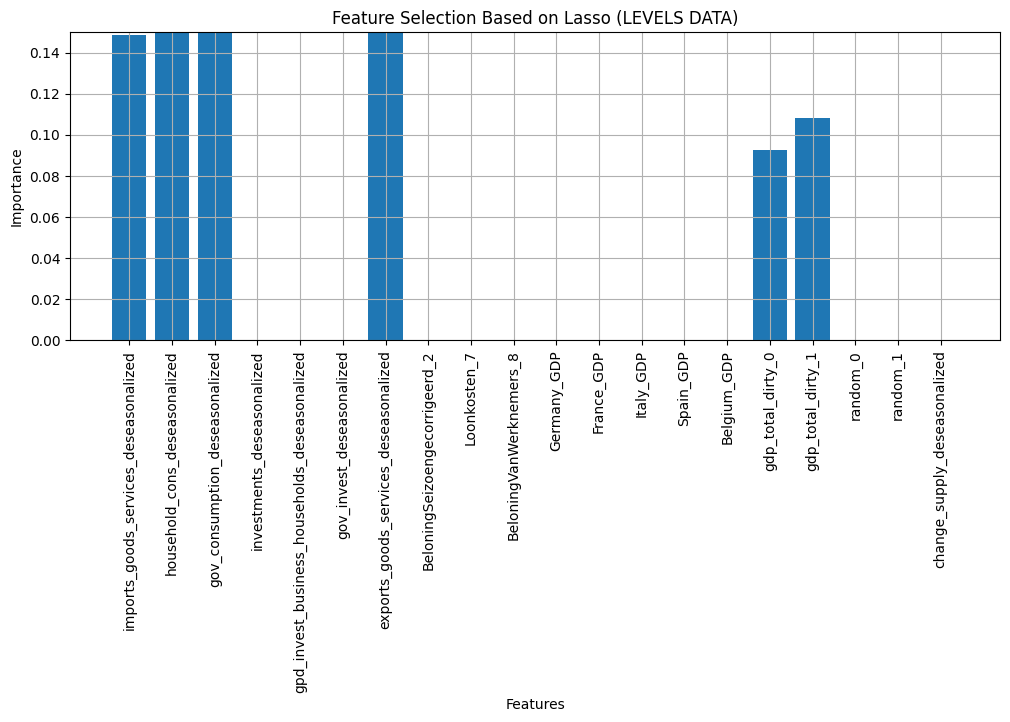

(111, 21)


In [5713]:
def lassoreg(data, alpha=0.0001, title='Feature Selection Based on Lasso'):

    myalpha = alpha
    data1 = data.copy()
    data1 = data1.dropna()

    Xcolnames =  data1.iloc[:, 1:]

    Y = data1.iloc[:, 0].values
    X = data1.iloc[:, 1:].values

    ### assertions
    # does X contain gdptotal, it should not
    assert X.shape[1] == data.shape[1] - 1

    # does X contain gdptotal, it should not
    val = 'gdp_total'
    lst = Xcolnames.columns
    assert val not in lst

    # regression
    lasso = Lasso(alpha = myalpha, fit_intercept=False, max_iter=10000)
    
    lasso.fit(X,Y)

    selected_features_lasso = np.flatnonzero(lasso.coef_)
    print(selected_features_lasso)

    best_variables = [Xcolnames.columns[i] for i in selected_features_lasso]
    print(best_variables)


    # calling the model with the best parameter
    lasso1 = Lasso(alpha=myalpha)
    lasso1.fit(X, Y)

    # Using np.abs() to make coefficients positive.  
    lasso1_coef = np.abs(lasso1.coef_)

    # plotting the Column Names and Importance of Columns. 
    plt.bar(lst, lasso1_coef)
    plt.xticks(rotation=90)
    plt.grid()
    plt.title(title)
    plt.xlabel("Features")
    plt.ylabel("Importance")
    plt.ylim(0, 0.15)
    plt.show()

    return best_variables

lassoreg(scaled_features_df, alpha=0.1, title='Feature Selection Based on Lasso (LEVELS DATA)')

print(scaled_features_df.shape)

[ 1  2  4  6  9 10 12 15 16 17 19]
['household_cons_deseasonalized', 'gov_consumption_deseasonalized', 'gpd_invest_business_households_deseasonalized', 'exports_goods_services_deseasonalized', 'BeloningVanWerknemers_8', 'Germany_GDP', 'Italy_GDP', 'gdp_total_dirty_0', 'gdp_total_dirty_1', 'random_0', 'change_supply_deseasonalized']


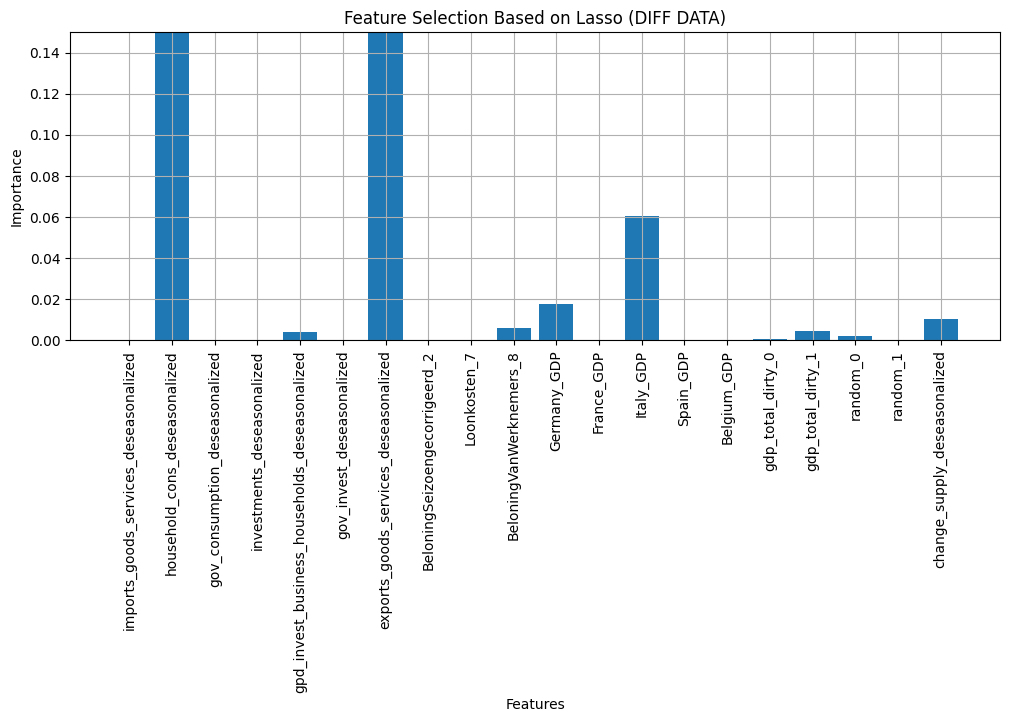

['household_cons_deseasonalized',
 'gov_consumption_deseasonalized',
 'gpd_invest_business_households_deseasonalized',
 'exports_goods_services_deseasonalized',
 'BeloningVanWerknemers_8',
 'Germany_GDP',
 'Italy_GDP',
 'gdp_total_dirty_0',
 'gdp_total_dirty_1',
 'random_0',
 'change_supply_deseasonalized']

In [5714]:
lassoreg(scaled_features_df.diff().dropna(), alpha=0.001, title='Feature Selection Based on Lasso (DIFF DATA)') 

In [5715]:
df1 = scaled_features_df.copy()
number_lags = 1

df = df1.iloc[:,:]

for lag in range(1, number_lags+1):
    for col in df.columns:
        df[col + '_lag_' + str(lag)] = df[col].shift(lag)
    
selectThese = [col for col in df.columns if '_lag_' in col]
selectThese = ['gdp_total', 'gdp_total_dirty_0', 'gdp_total_dirty_1','random_0', 'random_1'] + selectThese 
df_lag = df[selectThese]

print(df_lag.shape)


(111, 26)


[ 0  1  4  8 11 12 16 17 18 19 20 21 24]
['gdp_total_dirty_0', 'gdp_total_dirty_1', 'gdp_total_lag_1', 'investments_deseasonalized_lag_1', 'exports_goods_services_deseasonalized_lag_1', 'BeloningSeizoengecorrigeerd_2_lag_1', 'France_GDP_lag_1', 'Italy_GDP_lag_1', 'Spain_GDP_lag_1', 'Belgium_GDP_lag_1', 'gdp_total_dirty_0_lag_1', 'gdp_total_dirty_1_lag_1', 'change_supply_deseasonalized_lag_1']


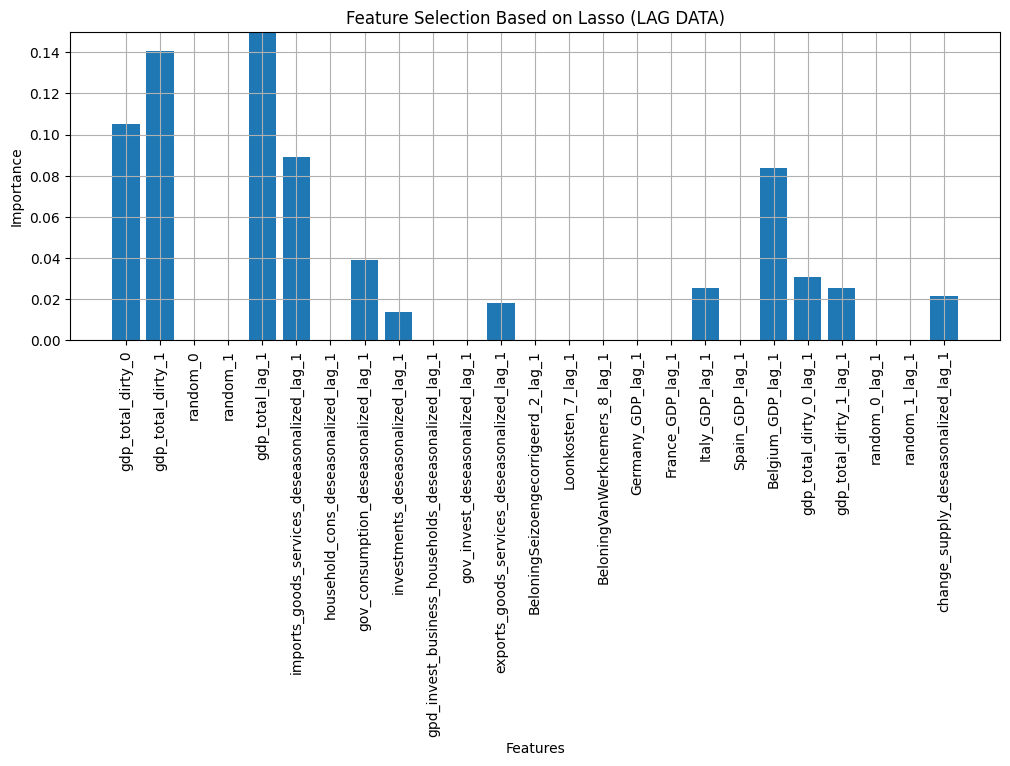

['gdp_total_dirty_0',
 'gdp_total_dirty_1',
 'gdp_total_lag_1',
 'investments_deseasonalized_lag_1',
 'exports_goods_services_deseasonalized_lag_1',
 'BeloningSeizoengecorrigeerd_2_lag_1',
 'France_GDP_lag_1',
 'Italy_GDP_lag_1',
 'Spain_GDP_lag_1',
 'Belgium_GDP_lag_1',
 'gdp_total_dirty_0_lag_1',
 'gdp_total_dirty_1_lag_1',
 'change_supply_deseasonalized_lag_1']

In [5716]:
lassoreg(df_lag, alpha=0.01, title='Feature Selection Based on Lasso (LAG DATA)') 

[ 0  1  2  3  6  8 15 16 17 20 21 22 24]
['gdp_total_dirty_0', 'gdp_total_dirty_1', 'random_0', 'random_1', 'household_cons_deseasonalized_lag_1', 'investments_deseasonalized_lag_1', 'Germany_GDP_lag_1', 'France_GDP_lag_1', 'Italy_GDP_lag_1', 'gdp_total_dirty_0_lag_1', 'gdp_total_dirty_1_lag_1', 'random_0_lag_1', 'change_supply_deseasonalized_lag_1']


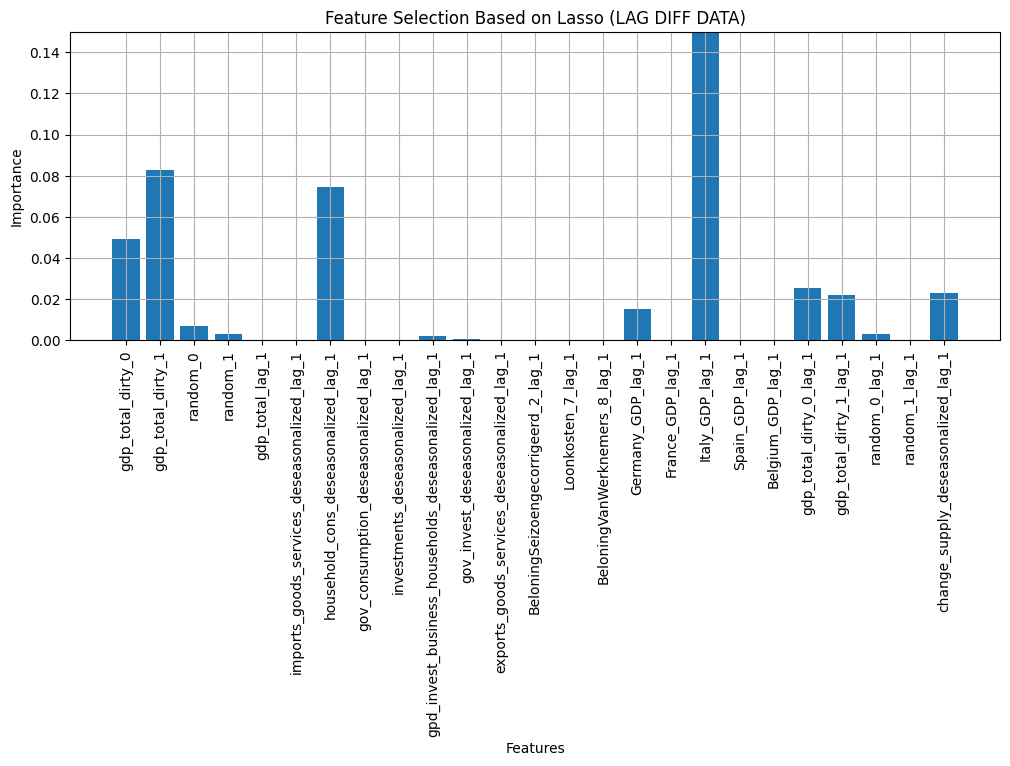

['gdp_total_dirty_0',
 'gdp_total_dirty_1',
 'random_0',
 'random_1',
 'household_cons_deseasonalized_lag_1',
 'investments_deseasonalized_lag_1',
 'Germany_GDP_lag_1',
 'France_GDP_lag_1',
 'Italy_GDP_lag_1',
 'gdp_total_dirty_0_lag_1',
 'gdp_total_dirty_1_lag_1',
 'random_0_lag_1',
 'change_supply_deseasonalized_lag_1']

In [5717]:
lassoreg(df_lag.diff().dropna(), alpha=0.001, title='Feature Selection Based on Lasso (LAG DIFF DATA)') 


### Make sure data is stationary

In [5718]:

# adf test, if critical value is greater than test statistic, then the series is not stationary

def adf_test(timeseries, verbose=False):
    if verbose:
        print ('Results of Dickey-Fuller Test:')
    
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    
    if verbose:
        print (dfoutput)
        print(dftest)

    if dftest[0] > dftest[4]['5%']:
        if verbose:
            print('ADF: Time Series is not Stationary')
       
        return "NotStationary"
    else:
        if verbose:    
            print('ADF: Time Series is Stationary') 
        return "Stationary" 


# adf_test(timeseries, verbose=True)   


In [5719]:

def kpss_test(timeseries, verbose=False):

    if verbose:
        print ('Results of KPSS Test:')

    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    
    if verbose:
        print (kpss_output)
        print(kpsstest[0])
        print(kpsstest[3])

    if kpsstest[0] > kpsstest[3]['5%']:
        if verbose:
            print('KPSS: Time Series is not Stationary')
        return "NotStationary"
    else: 
        if verbose:   
            print('KPSS: Time Series is Stationary')
        return "Stationary"

# kpss_test(timeseries, verbose=True) 

### Loop through KPSS and ADF tests, mark those series that need to be differenced

In [5720]:
def stationdarydf(mydata, STORE_FOR_TESTS, form='Levels', save=False):

    stationary_features = []
    seriesLength = []

    for col in mydata.columns:

        timeseries = mydata[col].dropna()
        seriesLength.append(len(timeseries))

        adf1 = adf_test(timeseries, verbose=False)
        kpss1 = kpss_test(timeseries, verbose=False)
        if adf1 == "Stationary" and kpss1 == "Stationary":
            stationary_features.append('Stationary')
            if form == 'Levels':
                STORE_FOR_TESTS.loc[col, 'Level_Stationary'] = 'Stationary'
            else:
                STORE_FOR_TESTS.loc[col, 'Difference_Stationary'] = 'Stationary'
        else:
            stationary_features.append('NotStationary')
            if form == 'Levels':
                STORE_FOR_TESTS.loc[col, 'Level_Stationary'] = 'NotStationary' 
            else:
                STORE_FOR_TESTS.loc[col, 'Difference_Stationary'] = 'NotStationary'
        
    df = pd.DataFrame(data = [mydata.columns, stationary_features, seriesLength]).T
    df.columns = ['Feature', 'Stationary', 'Length']    

    if save:
        df.to_csv(outputdata1 + "startionarity.csv")

    return df, STORE_FOR_TESTS

form = 'Levels'
df, STORE_FOR_TESTS = stationdarydf(scaled_features_df, STORE_FOR_TESTS, form, save=False)

print(df.shape)


(21, 3)


### If not stationary, difference, then test for stationarity again

In [5721]:

def differenceData(originalData, STORE_FOR_TESTS, mydiff=1):

    ## which features are not stationary
    # function from above
    stat1, _ = stationdarydf(originalData, STORE_FOR_TESTS, form, save=False)
    # collect
    stat2 = stat1[stat1['Stationary'].str.contains('NotStationary')]
    notstationary = stat2['Feature'].tolist()

    # dont change orginal data
    stationarydf_diff = originalData.copy()

    # selectively difference the data
    for i in notstationary:
        stationarydf_diff[i] = stationarydf_diff[i].diff(mydiff)

    # rename columns
    for col in notstationary:
        STORE_FOR_TESTS.loc[col, "Difference_Data"] = "True"
    
    scaled_features_df_diff = stationarydf_diff.copy()

    return scaled_features_df_diff, STORE_FOR_TESTS

scaled_features_df_diff, STORE_FOR_TESTS = differenceData(scaled_features_df, STORE_FOR_TESTS, mydiff=1)

print(scaled_features_df_diff.shape)


(111, 21)


In [5722]:

form = 'Differenced'
df1, STORE_FOR_TESTS = stationdarydf(scaled_features_df_diff, STORE_FOR_TESTS, form, save = 'False')

<Axes: >

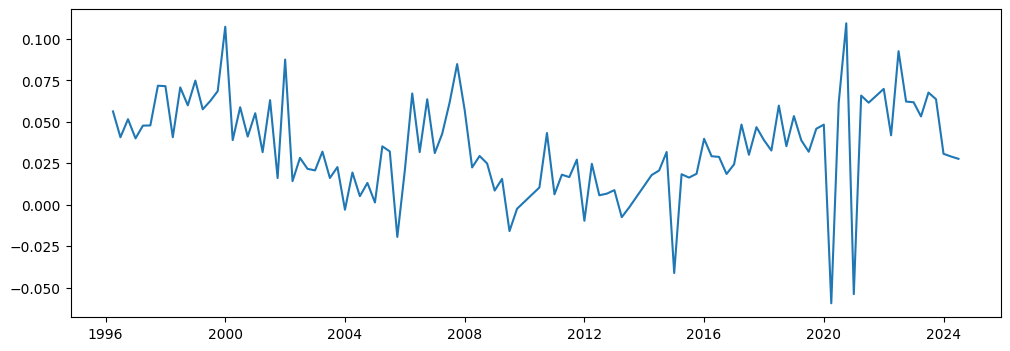

In [5723]:
scaled_features_df_diff['BeloningSeizoengecorrigeerd_2'].plot()

[ 1  2  4  6  9 10 12 15 16 17 19]
['household_cons_deseasonalized', 'gov_consumption_deseasonalized', 'gpd_invest_business_households_deseasonalized', 'exports_goods_services_deseasonalized', 'BeloningVanWerknemers_8', 'Germany_GDP', 'Italy_GDP', 'gdp_total_dirty_0', 'gdp_total_dirty_1', 'random_0', 'change_supply_deseasonalized']


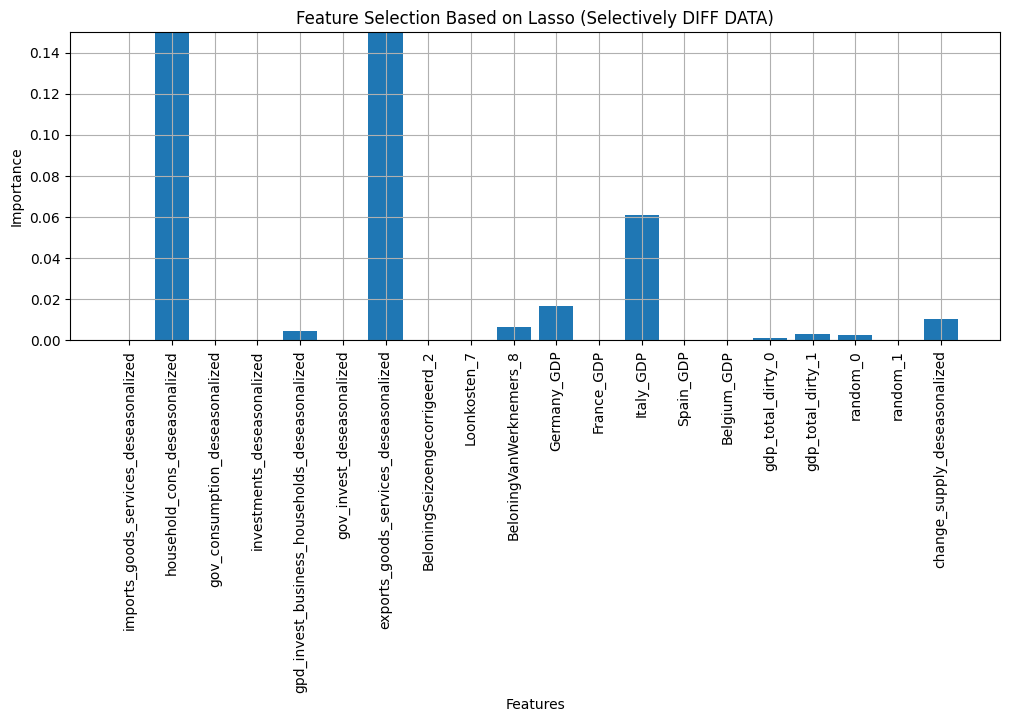

['household_cons_deseasonalized',
 'gov_consumption_deseasonalized',
 'gpd_invest_business_households_deseasonalized',
 'exports_goods_services_deseasonalized',
 'BeloningVanWerknemers_8',
 'Germany_GDP',
 'Italy_GDP',
 'gdp_total_dirty_0',
 'gdp_total_dirty_1',
 'random_0',
 'change_supply_deseasonalized']

In [5724]:
lassoreg(scaled_features_df_diff.dropna(), alpha=0.001, title='Feature Selection Based on Lasso (Selectively DIFF DATA)') 

(111, 21)


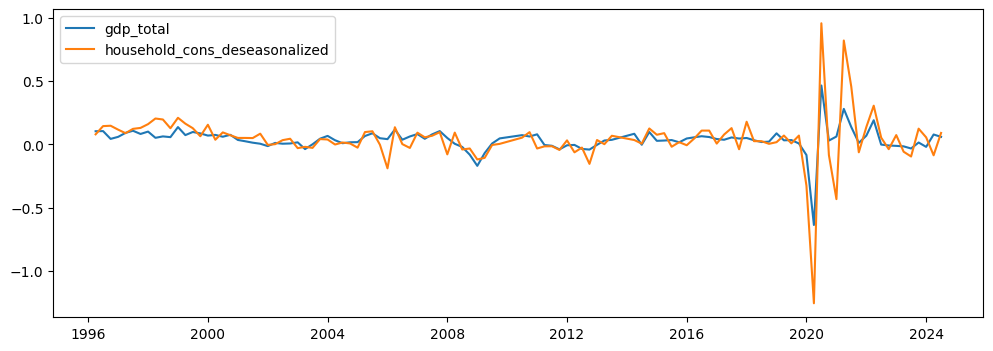

In [5725]:
scaled_features_df_diff[['gdp_total', 'household_cons_deseasonalized']].plot()
scaled_features_df_diff.columns

print(scaled_features_df_diff.shape)

In [5726]:
df = scaled_features_df_diff.copy()
number_lags = 1

for lag in range(1, number_lags+1):
    for col in df.columns:
        df[col + '_lag_' + str(lag)] = df[col].shift(lag)
    
selectThese = [col for col in df.columns if '_lag_' in col]
df_lag = df[selectThese]

scaled_features_df_diff_lag = scaled_features_df_diff.merge(df_lag, left_index=True, right_index=True)

print(scaled_features_df_diff_lag.shape)


(111, 42)


In [5727]:
### Select if lagged 

chooseThese = ['gdp_total'] + [x for x in scaled_features_df_diff_lag.columns if '_lag' in x]
scaled_features_df_diff_lag_subset = scaled_features_df_diff_lag[chooseThese]

print(scaled_features_df_diff_lag_subset.shape)

(111, 22)


In [5728]:
### Remove 'sure' data

removeThese = ['gdp_total_dirty_0_lag_1', 'gdp_total_dirty_1_lag_1', 'random_0_lag_1', 'random_1_lag_1']
scaled_features_df_diff_lag_subset = scaled_features_df_diff_lag_subset.loc[:, ~scaled_features_df_diff_lag_subset.columns.isin(removeThese)]

print(scaled_features_df_diff_lag_subset.shape)

(111, 18)


In [5729]:
scaled_features_df_diff_lag

,gdp_total,imports_goods_services_deseasonalized,household_cons_deseasonalized,gov_consumption_deseasonalized,investments_deseasonalized,gpd_invest_business_households_deseasonalized,gov_invest_deseasonalized,exports_goods_services_deseasonalized,BeloningSeizoengecorrigeerd_2,Loonkosten_7,...,Germany_GDP_lag_1,France_GDP_lag_1,Italy_GDP_lag_1,Spain_GDP_lag_1,Belgium_GDP_lag_1,gdp_total_dirty_0_lag_1,gdp_total_dirty_1_lag_1,random_0_lag_1,random_1_lag_1,change_supply_deseasonalized_lag_1
1996-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-04-01,0.104361,-0.004445,0.079805,0.034597,0.607777,0.524143,0.907064,-0.046666,0.056250,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.218206,NaN,NaN
1996-07-01,0.105454,0.067393,0.144762,0.029814,0.081653,0.089274,0.044445,0.090236,0.040654,NaN,...,0.188591,NaN,NaN,NaN,NaN,0.006521,0.047751,-0.647044,NaN,-0.230572
1996-10-01,0.043901,0.121560,0.147768,0.041372,0.304789,0.273264,0.379055,0.048991,0.051548,0.044251,...,0.198414,NaN,NaN,NaN,NaN,-0.187652,0.296700,-0.344448,NaN,-0.100693
1997-01-01,0.060052,0.064558,0.116784,0.050774,-0.201302,-0.058954,-1.104964,0.104786,0.039990,0.041967,...,0.172490,0.034896,0.024640,0.043551,0.056170,-0.327345,-0.535058,0.763712,-0.001223,-0.340021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-01,-0.031816,-0.114683,-0.094980,0.101575,-0.110056,-0.157143,0.288692,-0.076556,0.067605,0.059562,...,-0.215628,0.024084,0.000776,0.035996,0.007200,0.034875,0.139357,0.583225,-0.043076,1.791311
2023-10-01,0.015316,0.059267,0.124658,0.049498,-0.129710,-0.104860,-0.235675,0.058422,0.063612,0.046222,...,0.142444,0.032708,0.001447,0.046281,0.009390,-0.291832,-0.128805,0.283884,-0.167175,-1.533741
2024-01-01,-0.019072,-0.017790,0.056044,0.002832,0.049828,0.075853,-0.165444,-0.037040,0.030679,0.044857,...,0.166604,0.025203,0.017027,0.058778,0.014734,0.224202,0.015441,0.759305,-0.366188,-0.463333
2024-04-01,0.078594,0.032118,-0.085612,0.060912,0.048001,0.002631,0.363851,0.048629,0.029071,NaN,...,-0.121806,0.025758,0.009975,0.063857,0.041024,0.123137,-0.229152,0.885458,-0.194964,-0.076614


[ 2  6 11 12 13 16]
['household_cons_deseasonalized_lag_1', 'gov_invest_deseasonalized_lag_1', 'Germany_GDP_lag_1', 'France_GDP_lag_1', 'Italy_GDP_lag_1', 'change_supply_deseasonalized_lag_1']


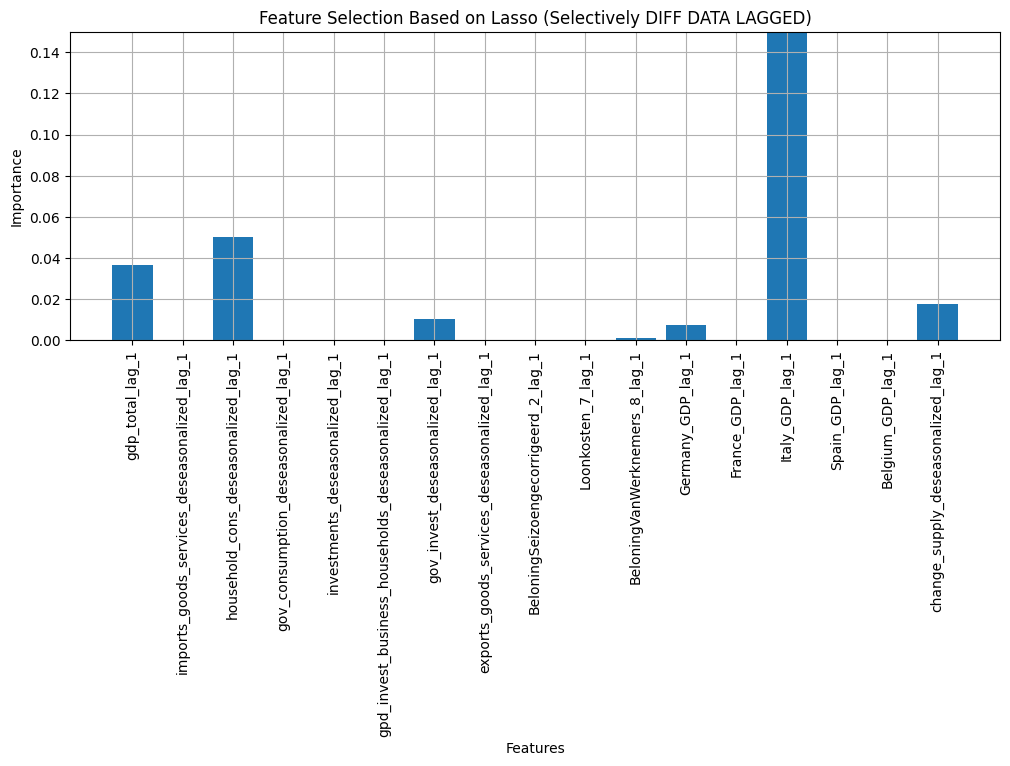

['household_cons_deseasonalized_lag_1',
 'gov_invest_deseasonalized_lag_1',
 'Germany_GDP_lag_1',
 'France_GDP_lag_1',
 'Italy_GDP_lag_1',
 'change_supply_deseasonalized_lag_1']

In [5730]:
lassoreg(scaled_features_df_diff_lag_subset.dropna(), alpha=0.001, title='Feature Selection Based on Lasso (Selectively DIFF DATA LAGGED)') 

In [5731]:
reg1 = scaled_features_df_diff_lag[['gdp_total', 'gdp_total_lag_1', 'household_cons_deseasonalized_lag_1', 'gov_invest_deseasonalized_lag_1', 'change_supply_deseasonalized_lag_1', 'Italy_GDP_lag_1']]
#reg1 = scaled_features_df_diff_lag[['gdp_total', 'investments_lag_1', 'household_cons_deseasonalized_lag_1', 'gov_invest_deseasonalized_lag_1', 'Italy_GDP_lag_1']]
reg1.to_csv("tmp.csv")
#reg1 = scaled_features_df_diff_lag[['random_0_lag_1', 'random_1_lag_1']]
reg1.dropna(inplace=True)

import statsmodels.api as sm

test_train_split = 104

X = reg1.iloc[0:test_train_split, 1:]
X = sm.add_constant(X)

y_true = reg1.iloc[0:test_train_split:, 0]

model = sm.OLS(y_true,X)
results = model.fit()
print(results.summary())


print(scaled_features_df_diff_lag.shape)
scaled_features_df_diff_lag

                            OLS Regression Results                            
Dep. Variable:              gdp_total   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.409
Method:                 Least Squares   F-statistic:                     15.23
Date:                Wed, 04 Dec 2024   Prob (F-statistic):           4.69e-11
Time:                        11:22:59   Log-Likelihood:                 126.45
No. Observations:                 104   AIC:                            -240.9
Df Residuals:                      98   BIC:                            -225.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co

,gdp_total,imports_goods_services_deseasonalized,household_cons_deseasonalized,gov_consumption_deseasonalized,investments_deseasonalized,gpd_invest_business_households_deseasonalized,gov_invest_deseasonalized,exports_goods_services_deseasonalized,BeloningSeizoengecorrigeerd_2,Loonkosten_7,...,Germany_GDP_lag_1,France_GDP_lag_1,Italy_GDP_lag_1,Spain_GDP_lag_1,Belgium_GDP_lag_1,gdp_total_dirty_0_lag_1,gdp_total_dirty_1_lag_1,random_0_lag_1,random_1_lag_1,change_supply_deseasonalized_lag_1
1996-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-04-01,0.104361,-0.004445,0.079805,0.034597,0.607777,0.524143,0.907064,-0.046666,0.056250,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.218206,NaN,NaN
1996-07-01,0.105454,0.067393,0.144762,0.029814,0.081653,0.089274,0.044445,0.090236,0.040654,NaN,...,0.188591,NaN,NaN,NaN,NaN,0.006521,0.047751,-0.647044,NaN,-0.230572
1996-10-01,0.043901,0.121560,0.147768,0.041372,0.304789,0.273264,0.379055,0.048991,0.051548,0.044251,...,0.198414,NaN,NaN,NaN,NaN,-0.187652,0.296700,-0.344448,NaN,-0.100693
1997-01-01,0.060052,0.064558,0.116784,0.050774,-0.201302,-0.058954,-1.104964,0.104786,0.039990,0.041967,...,0.172490,0.034896,0.024640,0.043551,0.056170,-0.327345,-0.535058,0.763712,-0.001223,-0.340021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-01,-0.031816,-0.114683,-0.094980,0.101575,-0.110056,-0.157143,0.288692,-0.076556,0.067605,0.059562,...,-0.215628,0.024084,0.000776,0.035996,0.007200,0.034875,0.139357,0.583225,-0.043076,1.791311
2023-10-01,0.015316,0.059267,0.124658,0.049498,-0.129710,-0.104860,-0.235675,0.058422,0.063612,0.046222,...,0.142444,0.032708,0.001447,0.046281,0.009390,-0.291832,-0.128805,0.283884,-0.167175,-1.533741
2024-01-01,-0.019072,-0.017790,0.056044,0.002832,0.049828,0.075853,-0.165444,-0.037040,0.030679,0.044857,...,0.166604,0.025203,0.017027,0.058778,0.014734,0.224202,0.015441,0.759305,-0.366188,-0.463333
2024-04-01,0.078594,0.032118,-0.085612,0.060912,0.048001,0.002631,0.363851,0.048629,0.029071,NaN,...,-0.121806,0.025758,0.009975,0.063857,0.041024,0.123137,-0.229152,0.885458,-0.194964,-0.076614


<Axes: >

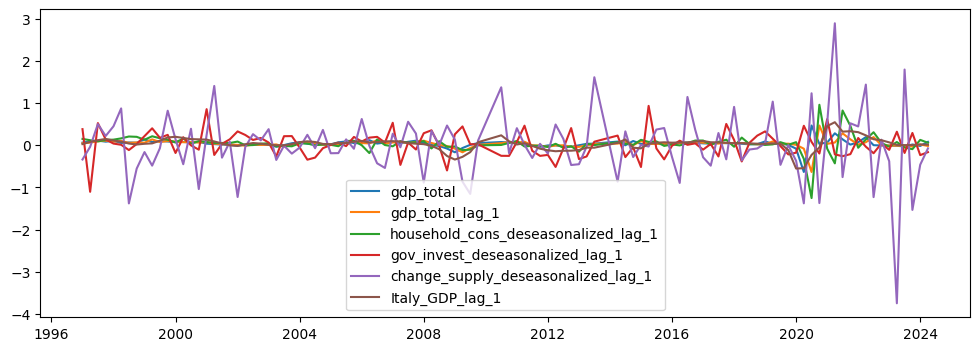

In [5732]:
reg1.plot()

In [5733]:
ypred = results.predict(X)
Xnew = reg1.iloc[test_train_split:, 1:]
Xnew[['const']] = 1

In [5734]:
reg1.iloc[test_train_split:, 0]

2024-01-01   -0.019072
2024-04-01    0.078594
Name: gdp_total, dtype: float64

<Axes: >

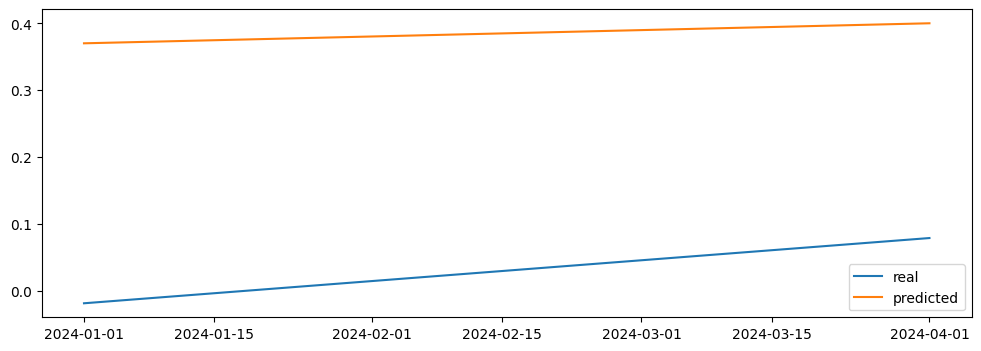

In [5735]:

ynewpred = results.predict(Xnew)  # predict out of sample

# plot real and predicted values
pd.DataFrame({'real': reg1.iloc[test_train_split:, 0], 'predicted': ynewpred}).plot()


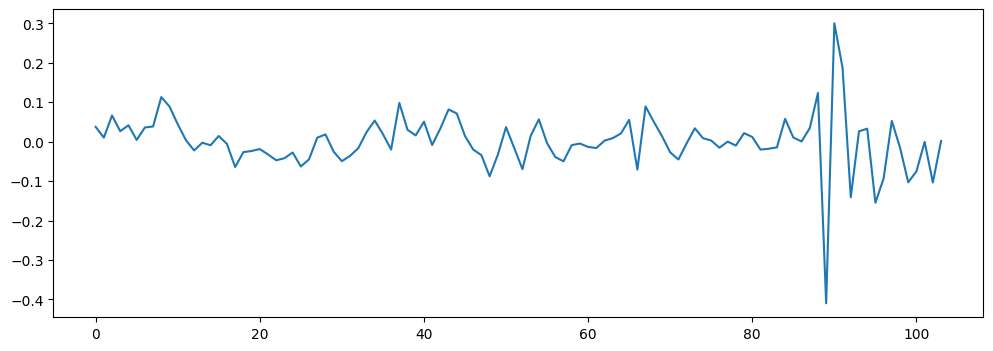

In [5736]:
plt.plot(np.arange(0,(len(results.resid))), results.resid)

### Remove Covid for tests

In [5737]:
# results.resid[results.resid < -0.4] = np.mean(results.resid)
# results.resid[results.resid > 0.2] = np.mean(results.resid)
# plt.plot(np.arange(0,(len(results.resid))), results.resid)

### Homoskedasticty

In [5738]:
homoske = sm.stats.diagnostic.het_breuschpagan(results.resid, X)
if homoske[1] < 0.10:
    print('Heteroskedasticity (Breusch-Pagan)')
else:
    print('Homoskedasticity (Breusch-Pagan)')

Heteroskedasticity (Breusch-Pagan)


In [5739]:
# Null hypothesis is homoscedastic and correctly specified.

homoske = sm.stats.diagnostic.het_white(results.resid, X)

if homoske[1] < 0.10:
    print('Heteroskedasticity (White)')
else:
    print('Homoskedasticity (White)')

Heteroskedasticity (White)


### Collinearity

In [5740]:
def dw_test(resids):

    dw1 = sm.stats.stattools.durbin_watson(resids, axis=0)
    print(dw1)

    if dw1 > 2.0:
        if (4 - dw1) < 1.8: 
            print("Negative autoceorrelation is significant")
        else:
            print("Negative autocorrelation is not significant")
    else:
        if dw1 < 1.8:
            print("Positive autocorrelation is significant")
        else:
            print("Positive autocorrelation is not significant")

dw_test(results.resid)

2.26356102786129
Negative autoceorrelation is significant


### Normality

Residuals are not normally distributed


(array([ 1.,  2., 66., 33.,  2.]),
 array([-0.40970732, -0.26773523, -0.12576315,  0.01620894,  0.15818103,
         0.30015312]),
 <BarContainer object of 5 artists>)

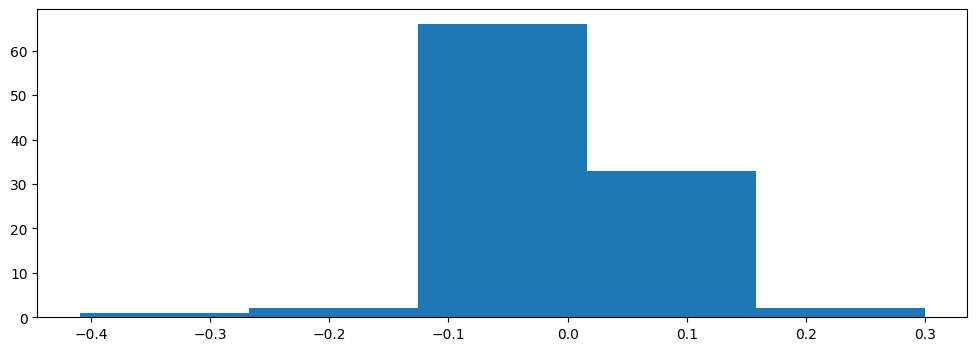

In [5741]:
def normality_test(resids):

    _, p = sm.stats.diagnostic.kstest_normal(resids)

    if p < 0.05:
        print("Residuals are not normally distributed")
    else:
        print("Residuals are normally distributed")


normality_test(results.resid)

plt.hist(results.resid, bins=5)

In [5742]:
STORE_FOR_TESTS

,Qt_Seasonality,Semi_Seasonality,Level_Stationary,Difference_Stationary,Difference_Data
gdp_total,No_Qt_Seasonality,No_Semi_Seasonality,NotStationary,Stationary,True
imports_goods_services_deseasonalized,No_Qt_Seasonality,No_Semi_Seasonality,NotStationary,Stationary,True
household_cons_deseasonalized,No_Qt_Seasonality,No_Semi_Seasonality,NotStationary,Stationary,True
gov_consumption_deseasonalized,No_Qt_Seasonality,No_Semi_Seasonality,NotStationary,Stationary,True
investments_deseasonalized,No_Qt_Seasonality,No_Semi_Seasonality,NotStationary,Stationary,True
gpd_invest_business_households_deseasonalized,No_Qt_Seasonality,No_Semi_Seasonality,NotStationary,Stationary,True
gov_invest_deseasonalized,No_Qt_Seasonality,No_Semi_Seasonality,NotStationary,Stationary,True
exports_goods_services_deseasonalized,No_Qt_Seasonality,No_Semi_Seasonality,NotStationary,Stationary,True
BeloningSeizoengecorrigeerd_2,No_Qt_Seasonality,No_Semi_Seasonality,NotStationary,NotStationary,True
Loonkosten_7,Qt_Seasonality,Semi_Seasonality,NotStationary,NotStationary,True
